# Project: Investigate Dataset "No-show appointments"

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset[1] collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment.

The investigation of the dataset will be focused on the following points:
- In the dataset we can see different characteristics about the patient such as hypertension, diabet, alcoholism, handicap, scholarship[2] and gender. There is also the information regarding the reception or not of an SMS used to remember the appointment to the patient. A first analisys is focused on which of mentioned characteristics majorly have impact on the fact that the patient showed up or not his appointment;
- The number of days between the day in which the appointment is fixed and the day of the appointment, can have an influence on fact that the patient showed up or not his appointment?
- Are there location[3] of the hospital that majorly involved on the missing appointments?

[1]original source on [Kaggle](https://www.kaggle.com/joniarroba/noshowappointment)\
[2]‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família\
[3]‘Neighborhood’ indicates the location of the hospital.

### Import statements for the packages that are going to be used

In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling
In this section we load the data and see the general structure of the dataset. If necessary, we will take some actions on the data in order to prepare them for the analisys.


### General Properties

In [212]:
# Read dataset
appointments=pd.read_csv('no_show_appointments.csv')
appointments.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [188]:
#number of samples and number of columns
appointments.shape

(110527, 14)

In [189]:
#General information about data: there are no missing values.
appointments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [190]:
#check for duplicated columns in the dataset: there are no duplicates in the dataset
appointments.duplicated().sum()

0

The previous information show that there are no missing values and no duplicates values in the dataset. We change the name of the columns:
- "No-show" to "No_show" to avoid issue on commands;
- "Scholarship" to "Bolsa_Familia_Program" just to remember the meaning of the column:

In [214]:
appointments = appointments.rename(columns={'No-show': 'No_show'})
appointments = appointments.rename(columns={'Scholarship': 'Bolsa_Familia_Program'})

In [215]:
#datatypes of columns
appointments.dtypes

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay              object
AppointmentDay            object
Age                        int64
Neighbourhood             object
Bolsa_Familia_Program      int64
Hipertension               int64
Diabetes                   int64
Alcoholism                 int64
Handcap                    int64
SMS_received               int64
No_show                   object
dtype: object

In [194]:
#datatypes of "object" columns
type(appointments['Gender'][0]),\
type(appointments['ScheduledDay'][0]),\
type(appointments['AppointmentDay'][0]),\
type(appointments['Neighbourhood'][0]),\
type(appointments['No_show'][0])

(str, str, str, str, str)

The "AppointmentDay" and the "ScheduledDay" columns are string.
We change the datatype in a datetime format:

In [216]:
#change the datatype of ScheduledDay and AppointmentDay columns 
appointments['ScheduledDay'] = pd.to_datetime(appointments['ScheduledDay'])
appointments['AppointmentDay'] = pd.to_datetime(appointments['AppointmentDay'])

In [217]:
#exploring values in some columns of the dataset
appointments['Gender'].unique(),\
appointments['Bolsa_Familia_Program'].unique(),\
appointments['Hipertension'].unique(),\
appointments['Diabetes'].unique(),\
appointments['Alcoholism'].unique(),\
appointments['Handcap'].unique(),\
appointments['SMS_received'].unique(),\
appointments['No_show'].unique()

(array(['F', 'M'], dtype=object),
 array([0, 1]),
 array([1, 0]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1, 2, 3, 4]),
 array([0, 1]),
 array(['No', 'Yes'], dtype=object))

From the above information:
- Gender has two possible values: "F" for female and "M" for male.
- The columns "Bolsa_Familia_Program", "Hipertension", "Diabetes", "Alcoholism" and "SMS_received":
  have two possible values "0" and "1". We assume that 1 stands for True and "0" for False.
- The column "Handcap" has five possible values from 0 to 4. We assume that it indicates the hadicap's gravity
   from 0: "None" to 4: "Very high" gravity of handicap. To better analyze the data for this column, we change 
   the datatype in string:

In [218]:
appointments['Handcap'] = appointments['Handcap'].astype(str)

### Data Cleaning:  set values for "Handcap" and "No-show" columns

In this section we change some data in order to simplify the analisys process of the data.
The first modification is related to the No_show column. If the value of this column is "Yes" means that 
the patient didn't show up his appointment and "No" viceversa. In order to avoid confusion, we change the
value "Yes" with "Not showed up" and the value "No" with "Showed up":

In [219]:
appointments.No_show.replace('Yes', 'Not Showed up', inplace=True)
appointments.No_show.replace('No', 'Showed up', inplace=True)

We have seen that the "Handcap" column has four possible values from 0 to 4. Assuming that these values indicate the gravity of handicap, to better analize this variable we replace the value of the column as follows:
- from "0" to "None";
- from "1" to "Low";
- from "2" to "Medium";
- from "3" to "High";
- from "4" to "Very High":

In [220]:
appointments.Handcap.replace('0', 'None', inplace=True)
appointments.Handcap.replace('1', 'Low', inplace=True)
appointments.Handcap.replace('2', 'Medium', inplace=True)
appointments.Handcap.replace('3', 'High', inplace=True)
appointments.Handcap.replace('4', 'Very High', inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis
In this section we will explore the data trying answering the reasearch questions listed in the "Introduction" section of this document.

### Question1: Which of the following characteristics seem to have a major impact on the fact that the patient showed up or not to his appointment: Hypertension, Diabet, Alcoholism, Handcap, SMS received, Gender and subscription to Bolsa Familia program?

We split the original dataset in two parts: 
- "no_showup_appointments" with all the data of appointments in which the patient DIDN'T showed up;
- "showup_appointments" with all the data of appointments in which the patient showed up:

In [221]:
no_showup_appointments=appointments.query('No_show == "Not Showed up"')
showup_appointments=appointments.query('No_show == "Showed up"')

We see some statistical properties of the datasets: "no_showup_appointments" and "showup_appointments"

In [203]:
#statistic properties of no_showup_appointments
no_showup_appointments.describe()

,PatientId,AppointmentID,Age,Bolsa_Familia_Program,Hipertension,Diabetes,Alcoholism,SMS_received
count,2.231900e+04,2.231900e+04,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000
mean,1.467523e+14,5.652259e+06,34.317667,0.115507,0.169004,0.064071,0.030333,0.438371
std,2.549905e+14,7.429686e+04,21.965941,0.319640,0.374764,0.244885,0.171505,0.496198
min,5.628261e+06,5.122866e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.176779e+12,5.614192e+06,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.156794e+13,5.657916e+06,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.454270e+13,5.703175e+06,51.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.996585e+14,5.789986e+06,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [222]:
#statistic properties of showup_appointments
showup_appointments.describe()

,PatientId,AppointmentID,Age,Bolsa_Familia_Program,Hipertension,Diabetes,Alcoholism,SMS_received
count,8.820800e+04,8.820800e+04,88208.000000,88208.000000,88208.000000,88208.000000,88208.000000,88208.000000
mean,1.476845e+14,5.681137e+06,37.790064,0.093903,0.204392,0.073837,0.030417,0.291334
std,2.563747e+14,6.931225e+04,23.338878,0.291695,0.403259,0.261507,0.171732,0.454380
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.168386e+12,5.646218e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.176184e+13,5.685684e+06,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.433715e+13,5.731078e+06,56.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From data above, "Bolsa_Familia_Program" and "SMS_received", seem to be the features that have majorly difference between the two dataset.\
Here below we create a function called "create_percentage" that we will use later for analisys.\
The function has three inputs: 
- "partial_df: this is the dataframe in input. In our case be "no_showup_appointments" or "showup_appointments". 
- "feature": this is the characteristic that we want to focus on. In our case can be "Alcoholism", "Diabetes", "Gender" and so on;
- "value": this is the value of the characteristic that we want to focus on. All features, except "Gender", have value "1" if the characteristic is present and "0" if not. In the case of "Gender" the two possible values will be "F" or "M".\
For example, the following command:\
`create_percentage(no_showup_appointments,'Diabetes',1)`\
will return the percentage of the diabetic patients that didn't showed up their appointments on the total of appointments of diabetic patients.

In [223]:
def create_percentage(partial_df, feature, value):
    total_feature=appointments.query('{}=="{}"'.format(feature,value))['AppointmentID'].count()
    partial_feature=partial_df.query('{}=="{}"'.format(feature, value))['AppointmentID'].count()

    perc_feature = (partial_feature/total_feature)*100
    return "{:.2f}".format(perc_feature)

In [25]:
create_percentage(no_showup_appointments,'Alcoholism',1),create_percentage(showup_appointments,'Alcoholism',1)

('20.15', '79.85')

As showed above, the 20,15% of the alcoholic patiens didn't show up at the appointment. But if we take a look at the patients that aren't alcoholist, we find more or less the same percentage.
This characteristic seem not affected the fact that a person showed up or not an appointment:

In [26]:
create_percentage(no_showup_appointments,'Alcoholism',0),create_percentage(showup_appointments,'Alcoholism',0)

('20.19', '79.81')

If we do the same with the "Gender", we'll find the same behavior:

In [224]:
create_percentage(no_showup_appointments,'Gender','F'),create_percentage(showup_appointments,'Gender','F')

('20.31', '79.69')

In [225]:
create_percentage(no_showup_appointments,'Gender','M'),create_percentage(showup_appointments,'Gender','M')

('19.97', '80.03')

Let's have a look to all the other characteristics grafically:

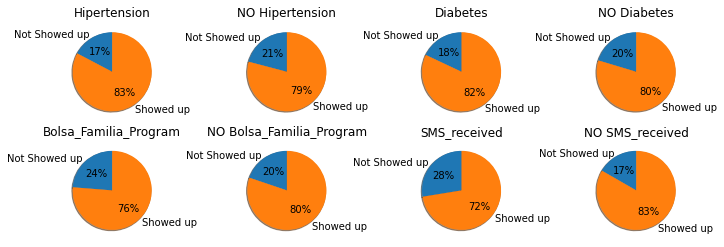

In [211]:
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
labels = 'Not Showed up', 'Showed up'
features =['Hipertension','Diabetes','Bolsa_Familia_Program','SMS_received']
i,j = 0,0
for feature in features:
    ax = axes[i, j]
    sizes=[create_percentage(no_showup_appointments,feature,1),create_percentage(showup_appointments,feature,1)]
    ax.pie(sizes, labels=labels,shadow=True, startangle=90, autopct='%1.0f%%')
    ax.set_title(feature)
    if (j!=3):
        j+=1
    ax = axes[i, j]
    sizes=[create_percentage(no_showup_appointments,feature,0),create_percentage(showup_appointments,feature,0)]
    ax.pie(sizes, labels=labels,shadow=True, startangle=90, autopct='%1.0f%%')
    ax.set_title("NO "+feature)
    if (j!=3):
        j+=1
    if (j==3):
        i+=1
        j=0
    
plt.show()

The presence or not of hypertension and diabetes, seem not to have weight on missed appointments. In the case of "SMS_received" we can note that despite the reception of the sms, we have the 28% of missed appointments against the 17% of missed appointments without the reception of the sms. Finally the percentage of the missed appointments are higher (24%) with people subscribed to the welfare program "Bolsa Familia" against the 20% for people not subscribed to this program. 

In [227]:
#we define some variables in order to analyse the "Handcap" characteristic.
#we call the percentage function with the different handicap's gravity and only for missed appointments:
prop_none= create_percentage(no_showup_appointments,'Handcap','None')
prop_low= create_percentage(no_showup_appointments,'Handcap','Low')
prop_medium=create_percentage(no_showup_appointments,'Handcap','Medium')
prop_high= create_percentage(no_showup_appointments,'Handcap','High')
prop_very_high=create_percentage(no_showup_appointments,'Handcap','Very High')

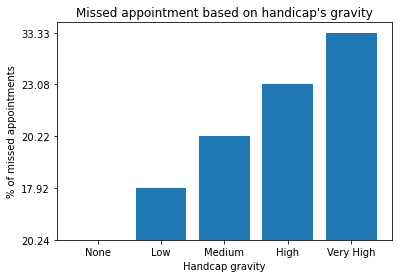

In [229]:
plt.bar([ "None", "Low","Medium","High","Very High"], [prop_none, prop_low, prop_medium, prop_high, prop_very_high])
plt.title("Missed appointment based on handicap's gravity")
plt.xlabel("Handcap gravity")
plt.ylabel("% of missed appointments");

### Question 2 : The number of days between the day in which the appointment is fixed and the day of the appointment, can have an influence on fact that the patient showed up or not his appointment?

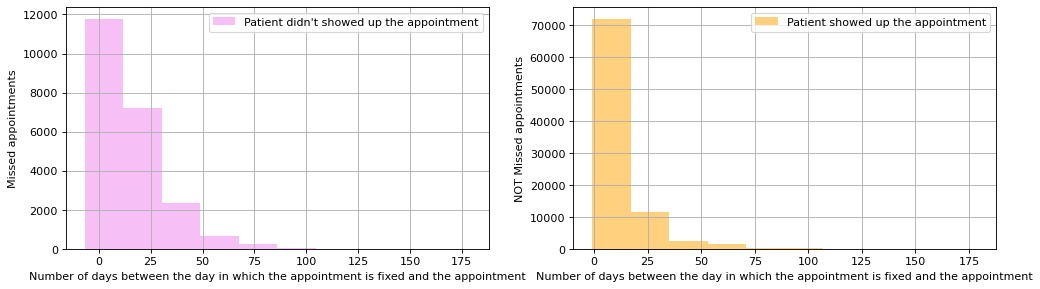

In [235]:
days_no_showup=(no_showup_appointments['AppointmentDay']-no_showup_appointments['ScheduledDay'])/np.timedelta64(1,'D')
days_showup=(showup_appointments['AppointmentDay']-showup_appointments['ScheduledDay'])/np.timedelta64(1,'D')

fig=plt.figure(figsize=(15,4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
days_no_showup.hist(alpha=0.5,color='violet',label="Patient didn't showed up the appointment")
plt.xlabel("Number of days between the day in which the appointment is fixed and the appointment")
plt.ylabel("Missed appointments")
plt.legend();

plt.subplot(1, 2, 2)
days_showup.hist(alpha=0.5,color='orange',label="Patient showed up the appointment")
plt.xlabel("Number of days between the day in which the appointment is fixed and the appointment")
plt.ylabel("NOT Missed appointments")
plt.legend();

In [236]:
days_no_showup.mean(), days_showup.mean()

(15.345543968517106, 8.289423895765523)

The mean of the difference between the day in which the appointment is fixed and the day of the appointment, is of about 15 days for missed appointments and 8 days for not missed appointments.

### Question 3: Are there location of the hospital that majorly involved on the missing appointments?

Number of total locations:

In [237]:
len(appointments['Neighbourhood'].unique())

81

Locations with more that 1000 missed appointments:

In [240]:
count_loc= no_showup_appointments.groupby('Neighbourhood')['No_show'].size()
count_loc[count_loc > 1000]

Neighbourhood
JARDIM CAMBURI    1465
MARIA ORTIZ       1219
Name: No_show, dtype: int64

It could be that this location have a big number of appointments. We consider the percentage of the missed appointments over the total appoitments for all the locations:

In [242]:
count_loc_tot= appointments.groupby('Neighbourhood')['No_show'].size()
percentage_loc=(count_loc/count_loc_tot)*100
new_percentage= percentage_loc.to_frame(name = 'count').reset_index()
new_percentage['count']=new_percentage['count'].astype(float)
new_percentage.mean()

count    20.799451
dtype: float64

The mean of missed appointments per location is about 20%. In the following table we consider the locations that are above this mean (for example the 26%) plus the two locations found above: "JARDIM CAMBURI","MARIA ORTIZ". 

In [243]:
new_percentage.query('count>=26 or Neighbourhood in ("JARDIM CAMBURI","MARIA ORTIZ")')

,Neighbourhood,count
34,ILHAS OCEÂNICAS DE TRINDADE,100.000000
36,ITARARÉ,26.266363
38,JARDIM CAMBURI,18.984061
43,MARIA ORTIZ,20.999139
61,SANTA CECÍLIA,27.455357
62,SANTA CLARA,26.482213
70,SANTOS DUMONT,28.918495


The two lacations "JARDIM CAMBURI","MARIA ORTIZ" have missed appointments near to the mean of the missed appointments of other locations. As regards the other locations of the table above, the first one is not a good sample of information because it has only two total appointments:

In [252]:
appointments.query('Neighbourhood in ("ILHAS OCEÂNICAS DE TRINDADE")')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Bolsa_Familia_Program,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
48754,5.349869e+11,5583947,F,2016-04-14 12:25:43+00:00,2016-05-13 00:00:00+00:00,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,None,0,Not Showed up
48765,7.256430e+12,5583948,F,2016-04-14 12:26:13+00:00,2016-05-13 00:00:00+00:00,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,None,0,Not Showed up


<a id='conclusions'></a>
## Conclusions

From the investigation of the dataset, we saw that different characteristics seem not to be related to the missed appointments: hypertension, diabet, alcoholism and and gender.\
In the case of "SMS_received" we can note that, despite the reception of the sms, we have the 28% of missed appointments against the 17% of missed appointments without the reception of the sms.\
The percentage of the missed appointments are higher (24%) with people subscribed to the welfare program "Bolsa Familia" against the 20% for people not subscribed to this program.\
The mean of the difference between the day in which the appointment is fixed, and the day of the appointment, is about 15 days for missed appointments and 8 days for not missed appointments.\
The locations with the percentage of missed appointments over the mean are: "ITARARÉ", "SANTA CECÍLIA", "SANTA CLARA" and "SANTOS DUMONT"